# Data Importing

In [2]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Changable_Parameter**

In [5]:
#here image size is 256x256
IMAGE_SIZE = 200
#every time process 32 images (61x31)~1951
batch_size = 10
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 25
NUM_CLASSES = 8
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=5
data_dir ="E:\\ICCIT\\mango\\MangoLeafBD Dataset\\MangoLeafBD Dataset"
split_folder = "E:\\ICCIT\\mango\\split"
model_name="densenet201"  

**Directory Creation and split**

In [7]:
import os
import shutil
import random
import math

# Example paths

train_val_dir = os.path.join(split_folder, "train_validation_data")
test_dir = os.path.join(split_folder, "test_data")

def split_data(source_folder, split_folder, train_val_ratio=0.9):
    # Check if split folders already exist
    if os.path.exists(train_val_dir) and os.path.exists(test_dir):
        print("Split folders already exist. Skipping data split.")
        return
    
    # Create split folders if they do not exist
    if not os.path.exists(split_folder):
        os.makedirs(split_folder)
    if not os.path.exists(train_val_dir):
        os.makedirs(train_val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    # Count variables
    train_val_count = 0
    test_count = 0
    
    # Iterate through source_folder (main folder with classes)
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        
        if os.path.isdir(class_path):
            # Create corresponding folders in split_folder
            train_val_class_path = os.path.join(train_val_dir, class_folder)
            test_class_path = os.path.join(test_dir, class_folder)
            
            if not os.path.exists(train_val_class_path):
                os.makedirs(train_val_class_path)
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)
            
            # List all images in the class folder
            images = [img for img in os.listdir(class_path) if img.endswith('.jpg') or img.endswith('.png')]
            random.shuffle(images)
            
            # Calculate split indices
            split_index = int(len(images) * train_val_ratio)
            
            # Split images into train_validation_data and test_data
            train_val_images = images[:split_index]
            test_images = images[split_index:]
            
            # Copy images to respective split folders
            for img in train_val_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(train_val_class_path, img)
                shutil.copy(src, dst)
                train_val_count += 1
                
            for img in test_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(test_class_path, img)
                shutil.copy(src, dst)
                test_count += 1
    
    print("Data split completed successfully.")
    print(f"Number of images in train_validation_data: {train_val_count}")
    print(f"Number of images in test_data: {test_count}")
    print(f"Total number of images: {train_val_count + test_count}")

# Call the function with your paths
split_data(data_dir, split_folder)


Data split completed successfully.
Number of images in train_validation_data: 3600
Number of images in test_data: 400
Total number of images: 4000


In [8]:
import os
import shutil
import random
import tensorflow as tf
# Define image parameters

# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.10+.03,  # 10% of the data will be used for validation
)

train_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


validation_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical'  # Update for multi-class classification
)


Found 3136 images belonging to 8 classes.
Found 464 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


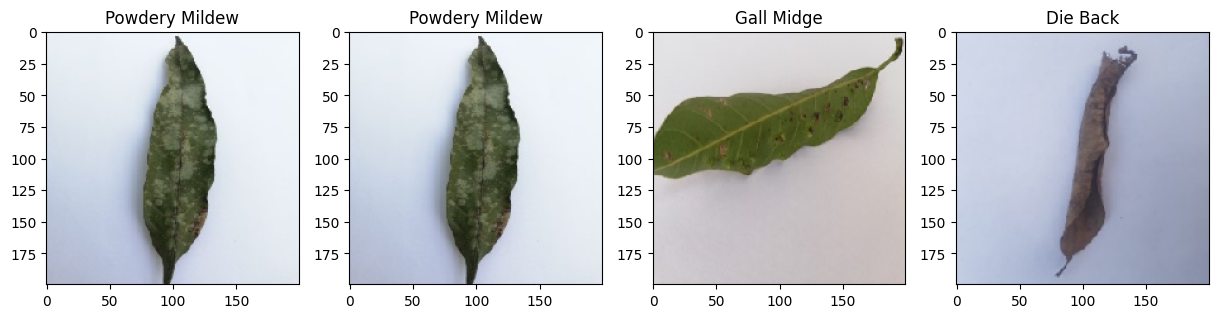

In [9]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, batch_size)
    
    # Plot the image
    axes[i].imshow(images[random_index])
    
    # Get the corresponding label
    label = labels[random_index]
    
    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [11]:
from tensorflow.keras.applications import EfficientNetV2B0,ResNet50,InceptionV3,NASNetMobile,EfficientNetV2L,DenseNet201

model= DenseNet201(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                 )

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 BatchNormalization False
8 Activation False
9 Conv2D False
10 BatchNormalization False
11 Activation False
12 Conv2D False
13 Concatenate False
14 BatchNormalization False
15 Activation False
16 Conv2D False
17 BatchNormalization False
18 Activation False
19 Conv2D False
20 Concatenate False
21 BatchNormalization False
22 Activation False
23 Conv2D False
24 BatchNormalization False
25 Activation False
26 Conv2D False
27 Concatenate False
28 BatchNormalization False
29 Activation False
30 Conv2D False
31 BatchNormalization False
32 Activation False
33 Conv2D False
34 Concatenate False
35 BatchNormalization False
36 Activation False
37 Conv2D False
38 BatchNormalization False
39 Activation False
40 Conv2D False
41 Concatenate False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 BatchNormalization False
46 Activation False
4

**Fine Tuning**

In [13]:
for layer in model.layers[:451]:
   layer.trainable = False
for layer in model.layers[451:]:
   layer.trainable = True

print('Last block of the conv_base is now trainable')
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

Last block of the conv_base is now trainable
0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36

In [14]:

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed on top of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.001))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    #top_model = Dropout(0.6)(top_model) 
    #top_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.6)(top_model) 
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [15]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)
#print(model.summary())

# Training

In [17]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 5:
         return .0009
     else:
        return .0009

lr_scheduler = LearningRateScheduler(scheduler)

In [18]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model") 
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

**CheckPoints**

In [20]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [21]:


model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    batch_size=batch_size,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,lr_scheduler,check,csv_logger],
                    initial_epoch=0)

Epoch 1/25
314/314 [==============================] - ETA: 0s - loss: 0.9077 - accuracy: 0.8830
Epoch 1: val_loss improved from inf to 0.41907, saving model to Model\densenet201_Model.hdf5
314/314 [==============================] - 76s 186ms/step - loss: 0.9077 - accuracy: 0.8830 - val_loss: 0.4191 - val_accuracy: 0.9871 - lr: 9.0000e-04
Epoch 2/25
314/314 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.9560
Epoch 2: val_loss improved from 0.41907 to 0.38162, saving model to Model\densenet201_Model.hdf5
314/314 [==============================] - 36s 114ms/step - loss: 0.4900 - accuracy: 0.9560 - val_loss: 0.3816 - val_accuracy: 0.9655 - lr: 9.0000e-04
Epoch 3/25
314/314 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.9713
Epoch 3: val_loss improved from 0.38162 to 0.35856, saving model to Model\densenet201_Model.hdf5
314/314 [==============================] - 36s 114ms/step - loss: 0.3586 - accuracy: 0.9713 - val_loss: 0.3586 - val_accura

**saving models**

In [23]:
import pickle

pickle_path_json = os.path.join("Results", f"{model_name}_model_architecture.json")
pickle_model_path = os.path.join("Model", f"{model_name}_model_pickle.pkl")

# Save model architecture to JSON (only needed once)
model_architecture = model.to_json()
with open(pickle_path_json, 'w') as f:
    f.write(model_architecture)

# Save model weights using pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://068cf349-5fbb-4e3a-8610-cf45f9f5814d/assets


In [24]:
model.save(f'{model_name}_.h5')

In [25]:
model = tf.keras.models.load_model(f'{model_name}_.h5')

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Result

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

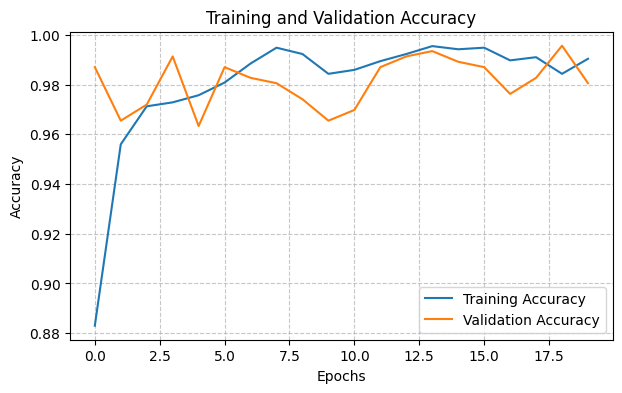

In [29]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

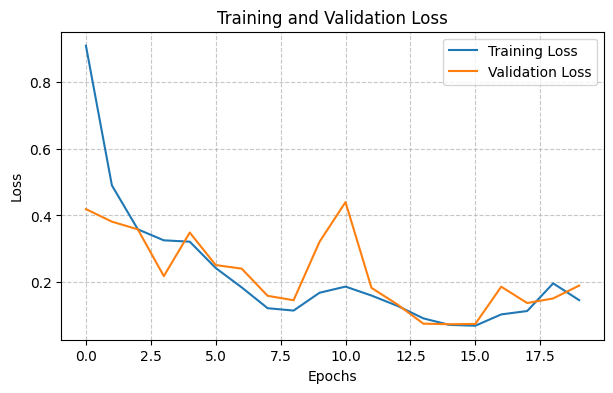

In [30]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
        

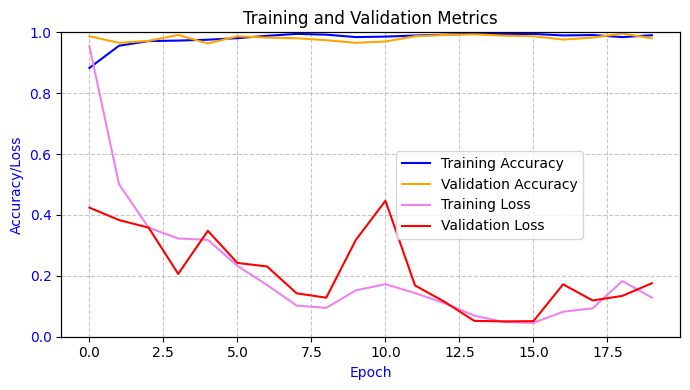

In [31]:
import matplotlib.pyplot as plt

# Assuming the following are defined:
# epochs: list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
# history: training history object containing 'accuracy', 'val_accuracy', 'loss', and 'val_loss' metrics

fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot Training and Validation Accuracy
ax1.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Set y-axis label and limits for accuracy
ax1.set_ylabel('Accuracy/Loss', color='blue')
ax1.set_xlabel('Epoch', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 1])  # Limit y-axis for accuracy between 0 and 1

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], label='Training Loss', color='violet')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')

# Hide y-axis ticks and labels for loss
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_ylabel('')  # Set empty string to hide the label

# Add grid, legends, title, and x-axis label
ax1.grid(True, linestyle='--', alpha=0.7)

# Combine legends for accuracy and loss in the middle right
handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Adjust legend position to be slightly left of center right
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.85, 0.5))

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')

# Show plot
plt.tight_layout()
plt.show()


In [32]:
score = model.evaluate(test_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

40/40 [==============================] - 5s 63ms/step - loss: 0.1289 - accuracy: 0.9950
Test Loss: 0.128936305642128
Test accuracy: 99.50000047683716


In [33]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_all, y_pred_all, target_names=class_labels, zero_division=1,digits=4)



In [34]:
print(report)

                  precision    recall  f1-score   support

     Anthracnose     0.9804    1.0000    0.9901        50
Bacterial Canker     1.0000    1.0000    1.0000        50
  Cutting Weevil     1.0000    1.0000    1.0000        50
        Die Back     1.0000    0.9800    0.9899        50
      Gall Midge     1.0000    1.0000    1.0000        50
         Healthy     1.0000    1.0000    1.0000        50
  Powdery Mildew     0.9804    1.0000    0.9901        50
     Sooty Mould     1.0000    0.9800    0.9899        50

        accuracy                         0.9950       400
       macro avg     0.9951    0.9950    0.9950       400
    weighted avg     0.9951    0.9950    0.9950       400



In [35]:
pip install numpy --upgrade


  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [36]:
pip install pandas scikit-image seaborn


Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install numpy==1.21.1

  Using cached numpy-1.21.1-cp38-cp38-win_amd64.whl.metadata (2.0 kB)
Using cached numpy-1.21.1-cp38-cp38-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


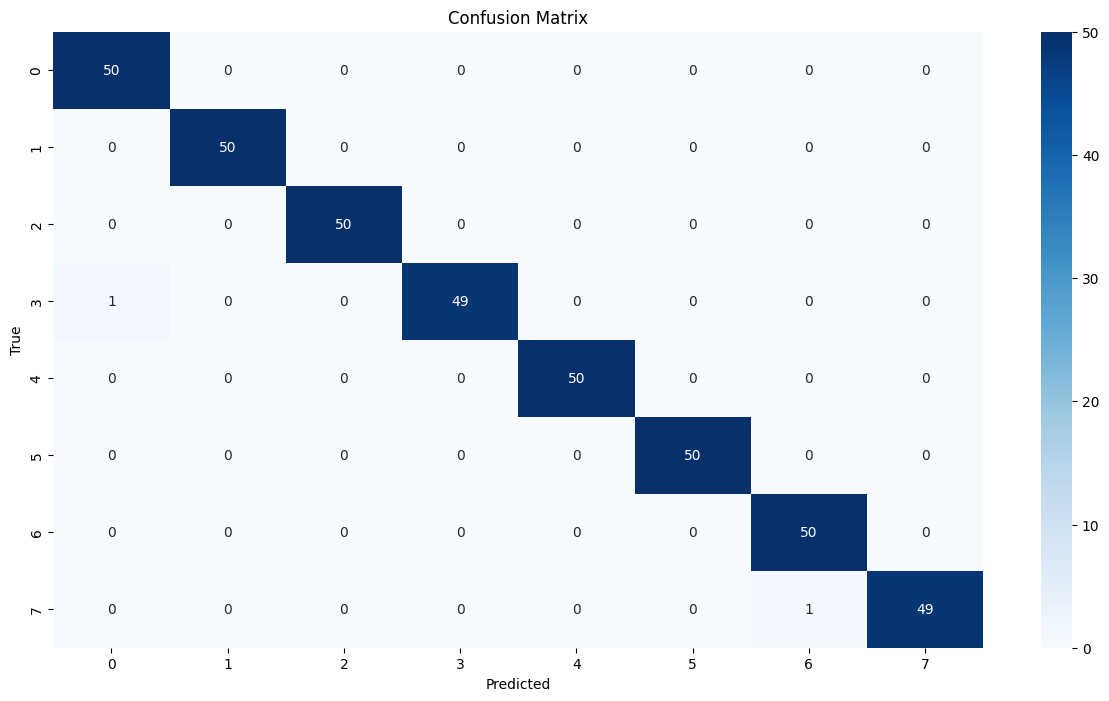

In [38]:
cm = confusion_matrix(y_true_all, y_pred_all)
import seaborn as sns
# Get class labels
class_labels = list(validation_generator.class_indices.keys())
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
# Plot confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

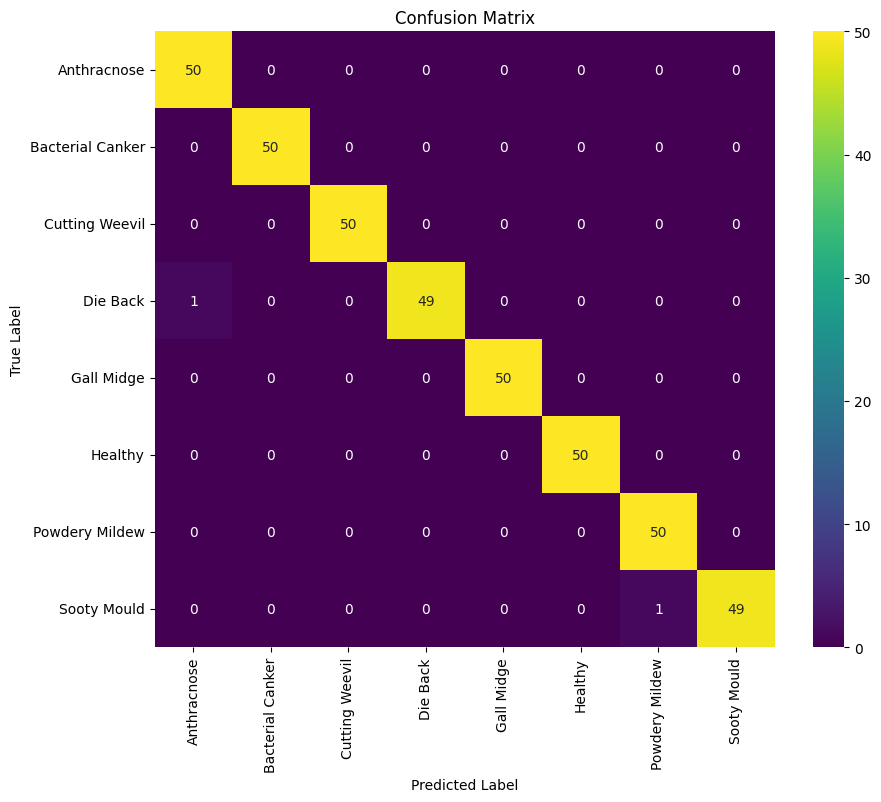

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Plot confusion matrix with a colorful palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [40]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

(400, 8)

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
labels = list(test_generator.class_indices.keys())

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

Error in generating ROC curve for Anthracnose. Dataset lacks enough examples.
Error in generating ROC curve for Bacterial Canker. Dataset lacks enough examples.
Error in generating ROC curve for Cutting Weevil. Dataset lacks enough examples.
Error in generating ROC curve for Die Back. Dataset lacks enough examples.
Error in generating ROC curve for Gall Midge. Dataset lacks enough examples.
Error in generating ROC curve for Healthy. Dataset lacks enough examples.
Error in generating ROC curve for Powdery Mildew. Dataset lacks enough examples.
Error in generating ROC curve for Sooty Mould. Dataset lacks enough examples.


<Figure size 640x480 with 0 Axes>

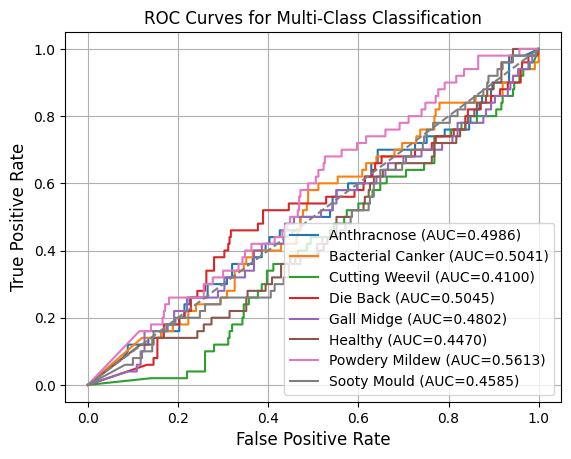

Anthracnose: ROC AUC = 0.4986
Bacterial Canker: ROC AUC = 0.5041
Cutting Weevil: ROC AUC = 0.4100
Die Back: ROC AUC = 0.5045
Gall Midge: ROC AUC = 0.4802
Healthy: ROC AUC = 0.4470
Powdery Mildew: ROC AUC = 0.5613
Sooty Mould: ROC AUC = 0.4585


In [80]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import metrics

# # Predict probabilities for the test data
# y_proba = model.predict(test_generator)
# y_true = test_generator.classes  # True labels

# # Get the class labels
# labels = list(test_generator.class_indices.keys())

# # Convert the true labels to one-hot encoding
# y_true_one_hot = np.eye(len(labels))[y_true]

# # Initialize dictionary to store AUC values for each class
# roc_auc_ovr = {}

# # Plot the ROC Curves One vs Rest
# for i in range(len(labels)):
#     # Get the class name
#     class_name = labels[i]

#     # Compute ROC curve and AUC for the current class
#     fpr, tpr, _ = metrics.roc_curve(y_true_one_hot[:, i], y_proba[:, i])
    
#     if np.isnan(fpr).any() or np.isnan(tpr).any():
#         print(f"Skipping class {class_name} due to NaN values.")
#         continue

#     roc_auc = metrics.auc(fpr, tpr)
#     roc_auc_ovr[class_name] = roc_auc

#     # Plot the ROC curve for the current class
#     plt.plot(fpr, tpr, label=f'{class_name} (AUC={roc_auc:.4f})')

# # Plot diagonal line for reference
# plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed')

# # Add labels, title, and legend
# plt.xlabel("False Positive Rate", fontsize=12)
# plt.ylabel("True Positive Rate", fontsize=12)
# plt.legend(loc="lower right")
# plt.title('ROC Curves for Multi-Class Classification')
# plt.grid(True)
# plt.show()

# # Print overall AUC scores for each class
# for class_name, auc_score in roc_auc_ovr.items():
#     print(f'{class_name}: ROC AUC = {auc_score:.4f}')


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming the following are defined:
# test_generator: the data generator for test data
# model: the trained model

# Predict probabilities for the test data
y_proba = model.predict(test_generator)
y_true = test_generator.classes  # True labels

# Get the class labels
labels = list(test_generator.class_indices.keys())

# Initialize dictionary to store specificity values for each class
specificity_ovr = {}

# Function to calculate specificity from confusion matrix
def calculate_specificity(cm):
    # For binary classification, cm[0,0] is TN, cm[0,1] is FP, cm[1,0] is FN, cm[1,1] is TP
    # For multi-class, we use the confusion matrix in a specific way to get TN and FP for each class
    # Here, we calculate specificity for the negative class (index 0 in our case)
    true_negative = cm[0, 0]  # TN
    false_positive = cm[0, 1]  # FP
    specificity = true_negative / (true_negative + false_positive + 1e-10)  # Adding a small epsilon to avoid division by zero
    return specificity

# Compute confusion matrix and specificity for each class
for i in range(len(labels)):
    # Get the class name
    c = labels[i]

    # Get predictions and true labels for the current class
    y_pred_class = np.argmax(y_proba, axis=1)
    y_true_class = np.where(y_true == i, 1, 0)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Calculate specificity for the current class
    specificity = calculate_specificity(cm)

    # Store the specificity value
    specificity_ovr[c] = specificity

# Print specificity scores for each class
for class_name, specificity in specificity_ovr.items():
    print(f'{class_name}: Specificity = {specificity:.4f}')


Anthracnose: Specificity = 0.5161
Bacterial Canker: Specificity = 0.5054
Cutting Weevil: Specificity = 0.5169
Die Back: Specificity = 0.5176
Gall Midge: Specificity = 0.5227
Healthy: Specificity = 0.5000
Powdery Mildew: Specificity = 0.4684
Sooty Mould: Specificity = 0.4889


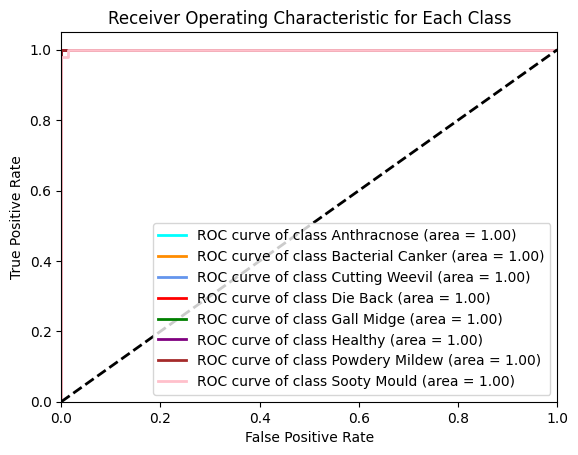

In [82]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []
y_pred_prob_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)
    y_pred_prob_all.extend(y_pred_prob)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Binarize the output
from sklearn.preprocessing import label_binarize
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true_all, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()
